In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('Numerical Features Continous Outcome.csv')

In [6]:
data

,Unnamed: 0,Annual_Income,Credit_Score,Debt_to_Income,Employment_Length,Age,Loan_Approval
0,0,65581.311290,505.502450,0.729998,12.762891,73,0.476365
1,1,120317.859109,483.101653,0.184512,9.185849,38,0.507581
2,2,99539.424472,396.884652,0.346640,19.289970,18,0.387672
3,3,86872.555999,633.996669,0.663281,4.379569,69,0.677483
4,4,44821.770842,562.143288,0.482089,11.757128,20,0.306824
...,...,...,...,...,...,...,...
9995,9995,111477.318883,782.371246,0.952275,15.080678,39,0.916532
9996,9996,115263.339335,325.747676,0.747824,15.290539,40,0.594636
9997,9997,119937.251928,467.034158,0.019456,5.391389,69,0.413762
9998,9998,67761.359280,543.826004,0.401005,8.686395,53,0.373033


In [8]:
data = data.drop(data.columns[[0]], axis=1)

In [10]:
data

,Annual_Income,Credit_Score,Debt_to_Income,Employment_Length,Age,Loan_Approval
0,65581.311290,505.502450,0.729998,12.762891,73,0.476365
1,120317.859109,483.101653,0.184512,9.185849,38,0.507581
2,99539.424472,396.884652,0.346640,19.289970,18,0.387672
3,86872.555999,633.996669,0.663281,4.379569,69,0.677483
4,44821.770842,562.143288,0.482089,11.757128,20,0.306824
...,...,...,...,...,...,...
9995,111477.318883,782.371246,0.952275,15.080678,39,0.916532
9996,115263.339335,325.747676,0.747824,15.290539,40,0.594636
9997,119937.251928,467.034158,0.019456,5.391389,69,0.413762
9998,67761.359280,543.826004,0.401005,8.686395,53,0.373033


In [12]:
X = data[["Annual_Income","Credit_Score","Debt_to_Income","Employment_Length","Age"]].values
y = data["Loan_Approval"].values.reshape(-1,1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [16]:
X_test_original = X_test.copy()

In [18]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [20]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_ds = TabularDataset(X_train, y_train)
test_ds  = TabularDataset(X_test,  y_test)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=4)

In [22]:
class TabularTransformer(nn.Module):
    def __init__(self, num_features=5, d_model=32, nhead=4, num_layers=2):
        super().__init__()
        # embed each scalar feature → d_model
        self.feature_embeds = nn.ModuleList([
            nn.Linear(1, d_model) for _ in range(num_features)
        ])
        # positional (feature-index) embeddings
        self.pos_embed = nn.Parameter(torch.randn(num_features, d_model))
        # transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # final head to scalar
        self.head = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [B, F]
        # embed each feature separately, then stack → [B, F, d_model]
        embs = [emb(x[:,i].unsqueeze(-1)) for i, emb in enumerate(self.feature_embeds)]
        x = torch.stack(embs, dim=1)                        # [B, F, d_model]
        x = x + self.pos_embed.unsqueeze(0)                 # add positional
        x = x.permute(1,0,2)                                # [F, B, d_model] for transformer
        x = self.transformer(x)                             # [F, B, d_model]
        x = x.permute(1,0,2)                                # [B, F, d_model]
        x = x.mean(dim=1)                                   # simple mean‐pool → [B, d_model]
        return self.head(x)                                 

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TabularTransformer().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [26]:
for epoch in range(30):
    model.train()
    total_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * xb.size(0)
    total_loss /= len(train_dl.dataset)
    # eval
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for xb, yb in test_dl:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += loss_fn(model(xb), yb).item() * xb.size(0)
        val_loss /= len(test_dl.dataset)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:02d}  train MSE={total_loss:.4f}  val MSE={val_loss:.4f}")


Epoch 00  train MSE=0.0062  val MSE=0.0003
Epoch 10  train MSE=0.0004  val MSE=0.0001
Epoch 20  train MSE=0.0002  val MSE=0.0001


In [28]:
model.eval()
with torch.no_grad():
    X_test_t = torch.from_numpy(X_test).float().to(device)
    preds = model(X_test_t).cpu().numpy().flatten()


In [38]:
print("True  :", y_test.flatten())
print("Preds :", preds)

True  : [0.42632969 0.64973306 0.6423571  ... 0.81625794 0.40076027 0.42606929]
Preds : [0.42238843 0.6546835  0.6329223  ... 0.81067765 0.3963406  0.421617  ]


In [40]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test.flatten(), preds)
r2  = r2_score         (y_test.flatten(), preds)

print(f"Test MSE: {mse:.4f}")
print(f"Test R² : {r2:.4f}")

Test MSE: 0.0000
Test R² : 0.9993


In [50]:
X_test_original

array([[6.20603193e+04, 3.53290689e+02, 9.68948492e-01, 1.15869475e+01,
        4.50000000e+01],
       [1.03673003e+05, 7.34158798e+02, 1.95105806e-01, 1.55752522e+01,
        2.50000000e+01],
       [8.92701044e+04, 4.14860361e+02, 9.89355015e-01, 1.13857296e+01,
        2.30000000e+01],
       ...,
       [8.92466339e+04, 8.35664566e+02, 6.30416028e-01, 8.55117887e+00,
        1.90000000e+01],
       [6.64428588e+04, 5.80706474e+02, 4.05352034e-01, 1.52133389e+01,
        3.00000000e+01],
       [7.01082622e+04, 5.78302934e+02, 4.21781485e-01, 1.36122904e+01,
        4.20000000e+01]])

In [52]:
cols = ["Annual_Income", "Credit_Score", "Debt_to_Income", "Employment_Length", "Age"]

# 2. Convert the NumPy arrays into DataFrames
X_test_df      = pd.DataFrame(X_test_original, columns=cols)

In [46]:
predictions_df = pd.DataFrame(preds.flatten(), columns=['Loan_Approval_Pred'])

In [59]:
merged_df = pd.concat([
    X_test_df.reset_index(drop=True),
    predictions_df.reset_index(drop=True)
], axis=1)

In [61]:
# merged_df.to_csv('Statistical Dataset for Numerical Features and Continous Outcome for Transformer.csv', index=False)

In [63]:
import statsmodels.api as sm
from scipy import stats

features = ['Annual_Income', 'Credit_Score', 'Debt_to_Income', 'Employment_Length', 'Age']
DV = 'Loan_Approval_Pred'

scaler = StandardScaler()
X_std = scaler.fit_transform(merged_df[features])
# Convert back to DataFrame for easier manipulation.
X_std_df = pd.DataFrame(X_std, columns=features)

# Define the target
y = merged_df[DV]

# # Add an intercept (constant) to the standardized features.
X_std_const = sm.add_constant(X_std_df)

# # ----------------------------
# # 3. Fit a Multiple Linear Regression Model
# # ----------------------------
model_std = sm.OLS(y, X_std_const)
results_std = model_std.fit()
print(results_std.summary())



scaler_y = StandardScaler()
y_std = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Add an intercept term to the standardized independent variables
X_std_const = sm.add_constant(X_std_df)

# ----------------------------
# 3. Fit the OLS Regression Model on Standardized Data
# ----------------------------
model_std = sm.OLS(y_std, X_std_const)
results_std = model_std.fit()
print("\nOLS Regression Summary on Standardized Data:")
print(results_std.summary())

# Extract Beta Weights (standardized coefficients) excluding the intercept.
beta_weights = results_std.params.drop('const')
print("\nBeta Weights (Standardized Coefficients):")
print(beta_weights)


                            OLS Regression Results                            
Dep. Variable:     Loan_Approval_Pred   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 4.580e+04
Date:                Thu, 01 May 2025   Prob (F-statistic):               0.00
Time:                        10:27:06   Log-Likelihood:                 6845.4
No. Observations:                3000   AIC:                        -1.368e+04
Df Residuals:                    2994   BIC:                        -1.364e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5080      0.00

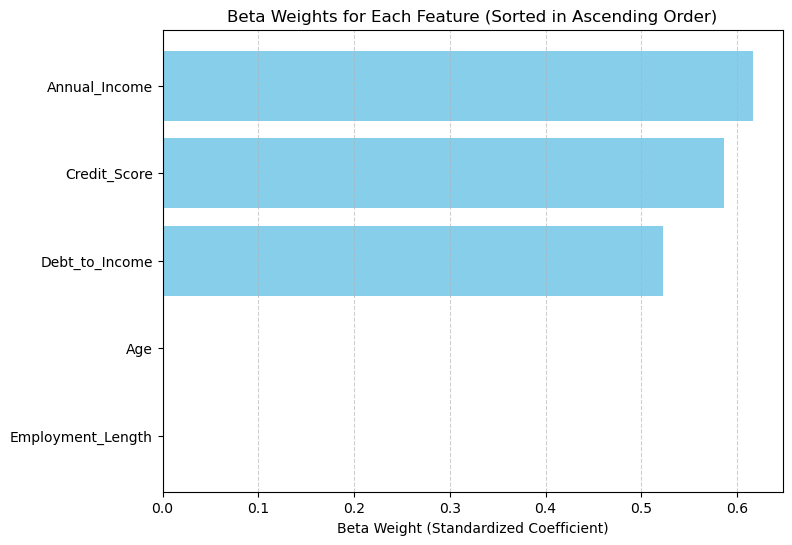

In [71]:
beta_weights_sorted = beta_weights.sort_values(ascending=True)

# Plot the sorted beta weights
plt.figure(figsize=(8, 6))
plt.barh(beta_weights_sorted.index, beta_weights_sorted.values, color='skyblue')
plt.xlabel("Beta Weight (Standardized Coefficient)")
plt.title("Beta Weights for Each Feature (Sorted in Ascending Order)")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

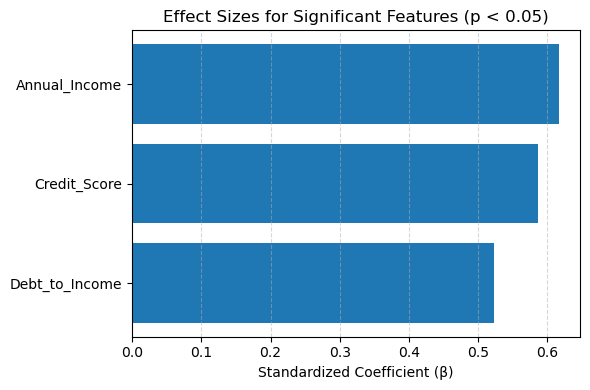

In [83]:
import matplotlib.pyplot as plt

# 1. grab p-values and beta‐weights (drop the intercept)
pvals        = results_std.pvalues.drop('const')
beta_weights = results_std.params .drop('const')

# 2. select only those features with p < .05
sig_feats    = pvals[pvals < 0.05].index
sig_betas    = beta_weights[sig_feats]

if len(sig_betas) == 0:
    print("No features reach p < 0.05.")
else:
    # 3. sort them by absolute effect size (largest first)
    sig_betas_sorted = sig_betas.reindex(
        sig_betas.abs().sort_values(ascending=True).index
    )

    # 4. plot a horizontal bar chart
    plt.figure(figsize=(6, 4))
    plt.barh(sig_betas_sorted.index, sig_betas_sorted.values)
    plt.xlabel("Standardized Coefficient (β)")
    plt.title("Effect Sizes for Significant Features (p < 0.05)")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [85]:
def compute_feature_recovery_metrics(gt, flagged, ranking):
    """
    Compute TP, FP, FN, Precision, Recall, FDR, and Top-1 Match for feature recovery.

    Parameters
    ----------
    gt : set
        Ground-truth causal features.
    flagged : list or set
        Features your method flagged as important (e.g., top‑k from ranking).
    ranking : list
        Ordered list of features by descending effect size.

    Returns
    -------
    pd.DataFrame
        Single-row DataFrame with the metrics.
    """
    tp = set(gt) & set(flagged)
    fp = set(flagged) - set(gt)
    fn = set(gt) - set(flagged)

    precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    recall    = len(tp) / len(gt)        if len(gt)              else 0.0
    fdr       = len(fp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    top1      = 1 if ranking and ranking[0] in gt else 0

    metrics = {
        "TP":           ", ".join(sorted(tp)),
        "FP":           ", ".join(sorted(fp)),
        "FN":           ", ".join(sorted(fn)),
        "Precision":     precision,
        "Recall":        recall,
        "FDR":           fdr,
        "Top-1 Match":   top1
    }
    return pd.DataFrame([{
        "Precision": precision,
        "Recall": recall,
        "FDR": fdr,
        "Top-1 Match": top1
    }])



if __name__ == "__main__":
    # Example:
    GT = {"annual_income", "credit_score", "debt_to_income"}
    ranking = [
        "annual_income",
        "credit_score",
        "debt_to_income",
    ]
    flagged = ranking[:3]  # e.g. top‑3 features

    df_metrics = compute_feature_recovery_metrics(GT, flagged, ranking)
    df_metrics.insert(0, "Method", "Stat-XAI")
    df_metrics = df_metrics[["Method", "Precision", "Recall", "FDR", "Top-1 Match"]]
    print(df_metrics.to_string(index=False))

  Method  Precision  Recall  FDR  Top-1 Match
Stat-XAI        1.0     1.0  0.0            1


In [42]:
import shap
import numpy as np
import psutil
import os
import torch.optim as optim
import matplotlib.pyplot as plt

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# 1) Build a pure‑NumPy wrapper for your model’s regression output
def predict_regression(x_np):
    """
    x_np: np.array shape (batch, 5)
    returns: np.array shape (batch,) of model outputs
    """
    with torch.no_grad():
        t = torch.from_numpy(x_np).float().to(device)    # [batch,5]
        out = model(t).cpu().numpy().flatten()           # [batch,]
    return out

In [76]:
bg_size    = 200
bg_indices = np.random.choice(len(X_train), size=bg_size, replace=False)
background = X_train[bg_indices]   # (200,5)


In [78]:
explainer = shap.KernelExplainer(predict_regression, background)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [80]:
batch_size = 512
all_shap   = []

for start in range(0, X_test.shape[0], batch_size):
    end   = min(start + batch_size, X_test.shape[0])
    Xb_np = X_test[start:end]                   # (batch,5)
    mem   = psutil.virtual_memory()
    print(f"Batch {start}-{end}: free RAM = {mem.available/1e9:.2f} GB")
    sv = explainer.shap_values(Xb_np, nsamples=100)  # (batch,5)
    all_shap.append(sv)


Batch 0-512: free RAM = 3.18 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 512-1024: free RAM = 3.40 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 1024-1536: free RAM = 3.50 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 1536-2048: free RAM = 3.47 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 2048-2560: free RAM = 3.67 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 2560-3000: free RAM = 3.96 GB


  0%|          | 0/440 [00:00<?, ?it/s]

In [82]:
all_shap_values = np.vstack(all_shap)

In [86]:
num_feats = ["Annual_Income","Credit_Score","Debt_to_Income","Employment_Length","Age"]

In [88]:
mean_abs = pd.Series(
    np.abs(all_shap_values).mean(axis=0),
    index=num_feats
).sort_values()


In [90]:
print("Mean |SHAP| per feature (regression):")
print(mean_abs)

Mean |SHAP| per feature (regression):
Age                  0.000120
Employment_Length    0.000173
Debt_to_Income       0.098703
Credit_Score         0.108717
Annual_Income        0.111993
dtype: float64


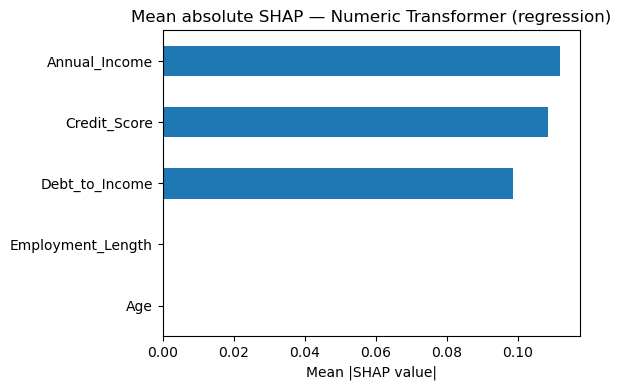

In [92]:
os.makedirs("shap", exist_ok=True)
plt.figure(figsize=(6,4))
mean_abs.plot.barh()
plt.xlabel("Mean |SHAP value|")
plt.title("Mean absolute SHAP — Numeric Transformer (regression)")
plt.tight_layout()
plt.savefig("shap/Traansformer_numeric_regression_shap.jpg", dpi=300)
plt.show()

In [94]:
def compute_feature_recovery_metrics(gt, ranking):
    """
    Compute TP, FP, FN, Precision, Recall, FDR, and Top-1 Match for feature recovery.

    Parameters
    ----------
    gt : set
        Ground-truth causal features.
    flagged : list or set
        Features your method flagged as important (e.g., top‑k from ranking).
    ranking : list
        Ordered list of features by descending effect size.

    Returns
    -------
    pd.DataFrame
        Single-row DataFrame with the metrics.
    """
    tp = set(gt) & set(ranking)
    fp = set(ranking) - set(gt)
    fn = set(gt) - set(ranking)

    precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    recall    = len(tp) / len(gt)        if len(gt)              else 0.0
    fdr       = len(fp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    top1      = 1 if ranking and ranking[0] in gt else 0

    metrics = {
        "TP":           ", ".join(sorted(tp)),
        "FP":           ", ".join(sorted(fp)),
        "FN":           ", ".join(sorted(fn)),
        "Precision":     precision,
        "Recall":        recall,
        "FDR":           fdr,
        "Top-1 Match":   top1
    }
    return pd.DataFrame([{
        "Precision": precision,
        "Recall": recall,
        "FDR": fdr,
        "Top-1 Match": top1
    }])



if __name__ == "__main__":
    # Example:
    GT = {"annual_income", "credit_score", "debt_to_income"}
    ranking = [
        "annual_income",
        "credit_score",
        "debt_to_income",
        "Employement_Length",
        "Age"
    ]
    # flagged = ranking[:3]  # e.g. top‑3 features

    df_metrics = compute_feature_recovery_metrics(GT, ranking)
    df_metrics.insert(0, "Method", "Stat-XAI")
    df_metrics = df_metrics[["Method", "Precision", "Recall", "FDR", "Top-1 Match"]]
    print(df_metrics.to_string(index=False))

  Method  Precision  Recall  FDR  Top-1 Match
Stat-XAI        0.6     1.0  0.4            1
